In [1]:
import sys
sys.path.remove("/rhome/naotok/.local/lib/python3.10/site-packages")

In [2]:
# import library
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 1000)
import scanpy as sc
from matplotlib import rcParams
# import matplotlib.pyplot as plt
import met_brewer.palettes
import seaborn as sns
import scrublet as scr
import anndata as ad
from anndata import AnnData

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

-----
anndata     0.9.2
scanpy      1.9.5
-----
PIL                 9.2.0
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.5
cffi                1.15.1
cloudpickle         2.2.0
colorama            0.4.5
colour              NA
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2022.9.2
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
defusedxml          0.7.1
dill                0.3.5.1
entrypoints         0.4
executing           1.1.1
fsspec              2022.8.2
gmpy2               2.1.2
google              NA
h5py                3.7.0
hypergeom_ufunc     NA
igraph              0.10.1
ipykernel           6.16.0
ipython_genutils    0.2.0
ipywidgets          8.0.2
jedi                0.18.1
jinja2              3.1.2
joblib              1.2.0
jupyter_server      1.21.0
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.39

In [3]:
%matplotlib inline

In [4]:
# Set datapath
datapath = "/home/bigdata/Upf2_paper/Aug23/STARsolo"

In [5]:
# Set results file
results_file = datapath + "/scanpy/results_4.h5ad"  # the file that will store the analysis results

In [6]:
sc.settings.figdir = datapath + "/scanpy/figures_4/"
sc.settings.cachedir = datapath + "/scanpy/cache/"

... reading from cache file /home/bigdata/Upf2_paper/Aug23/STARsolo/scanpy/cache/home-bigdata-Upf2_paper-Aug23-STARsolo-Ctrl-Solo.out-GeneFull-filtered-matrix.h5ad
... reading from cache file /home/bigdata/Upf2_paper/Aug23/STARsolo/scanpy/cache/home-bigdata-Upf2_paper-Aug23-STARsolo-KO-Solo.out-GeneFull-filtered-matrix.h5ad
filtered out 9112 genes that are detected in less than 2 cells


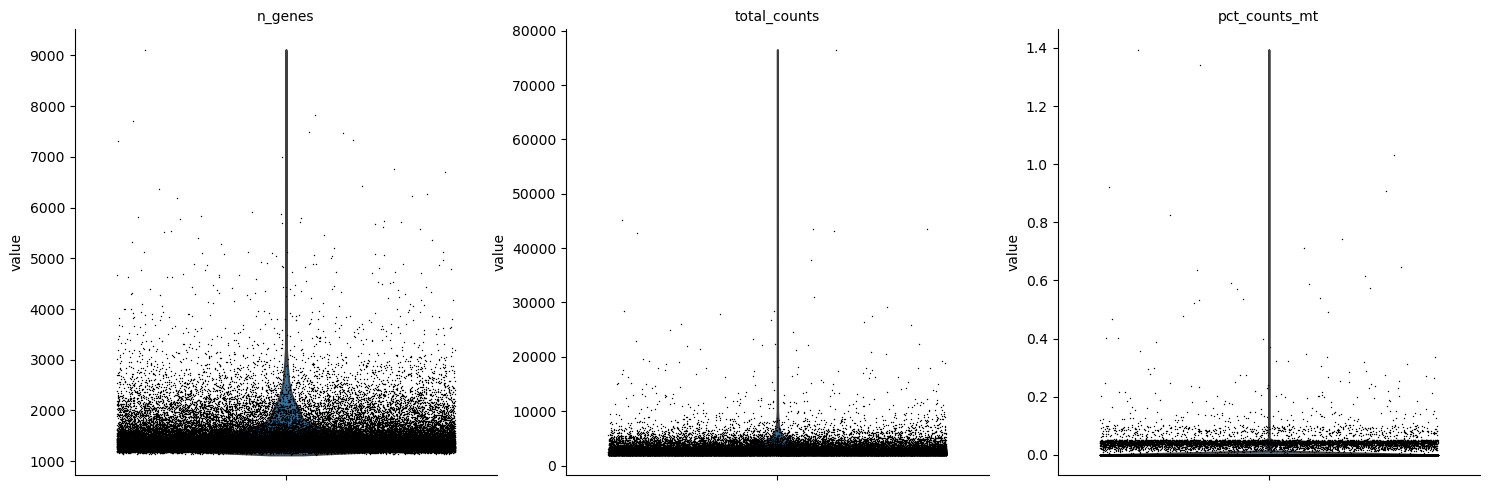

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.69
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 3.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.5%
Elapsed time: 9.2 seconds


/scratch/naotok/322758/ipykernel_3811842/3344934959.py:60: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  samples[i].obs['Doublet'] = scrub.predicted_doublets_


filtered out 9683 genes that are detected in less than 2 cells


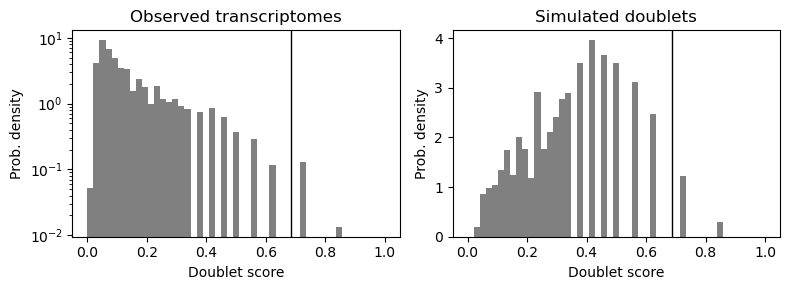

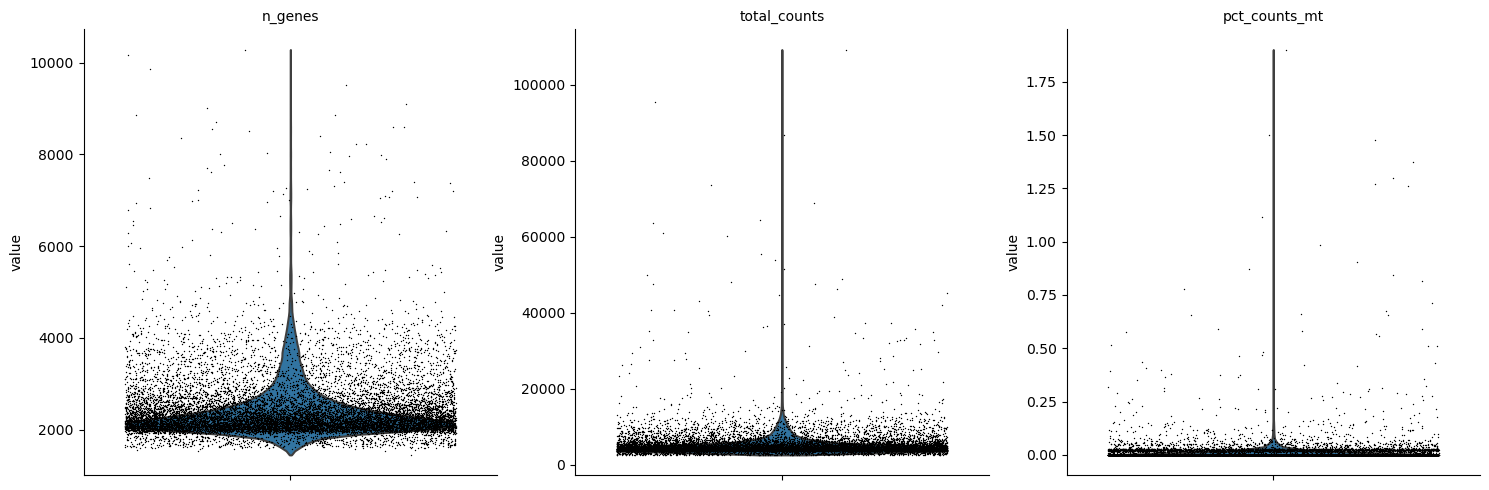

Preprocessing...


/opt/conda/lib/python3.10/site-packages/scrublet/helper_functions.py:241: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.81
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.4%
Elapsed time: 38.1 seconds


/scratch/naotok/322758/ipykernel_3811842/3344934959.py:60: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  samples[i].obs['Doublet'] = scrub.predicted_doublets_


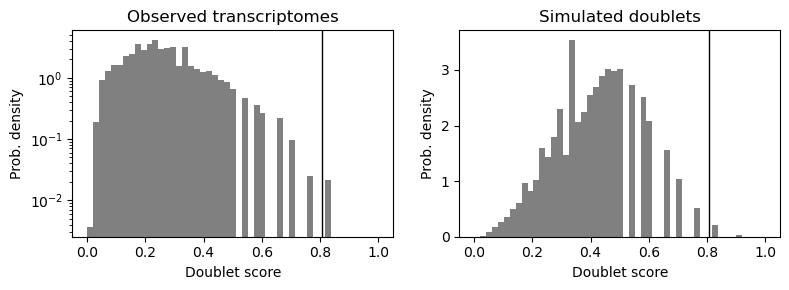

In [11]:
# load raw data
adata_Ctrl = sc.read_10x_mtx(
    
    datapath + "/Ctrl/Solo.out/GeneFull/filtered",  # the directory with the `.mtx` file
    var_names = 'gene_symbols',  # use gene symbols for the variable names (variables-axis index)
    cache = True

)

adata_KO = sc.read_10x_mtx(
    
    datapath + "/KO/Solo.out/GeneFull/filtered",  # the directory with the `.mtx` file
    var_names = 'gene_symbols',  # use gene symbols for the variable names (variables-axis index)
    cache = True

)

adata_Ctrl.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata_Ctrl.obs_names_make_unique()
adata_KO.var_names_make_unique()
adata_KO.obs_names_make_unique()

samples = [adata_Ctrl, adata_KO]
for i in range(len(samples)):
    
    # Filter out cells expressing <200 genes
    sc.pp.filter_cells(samples[i], min_genes = 200)

    # Filter out genes expressed in only one cell
    sc.pp.filter_genes(samples[i], min_cells = 2)

    samples[i].var['mt'] = samples[i].var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(samples[i], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    sc.pl.violin(

        samples[i],
        ['n_genes', 'total_counts', 'pct_counts_mt'],
        jitter=0.4,
        multi_panel=True,
        save = False

    )
    
    # Remove cells that have too many mitochondrial genes expressed or too many total counts or too small total counts 
    samples[i] = samples[i][samples[i].obs.total_counts < 10000, :] # too many total counts
    samples[i] = samples[i][samples[i].obs.pct_counts_mt < 1, :] # too many mitochondrial genes expressed
    if i == 0:
        samples[i] = samples[i][samples[i].obs.total_counts > 4000]
    
    # Doublet detection
    counts_matrix = samples[i].X
    scrub = scr.Scrublet(counts_matrix)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_cells=2, 
                                                              min_gene_variability_pctl=85, 
                                                              n_prin_comps=40)
    
    scrub.plot_histogram();

    samples[i].obs['Doublet'] = scrub.predicted_doublets_
    samples[i].obs['Doublet Score'] = scrub.doublet_scores_obs_

In [12]:
adata = samples[0].concatenate(samples[1], batch_categories = ["WT", "KO"])

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [13]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,Doublet,Doublet Score,batch
AAACCCAAGACTTCAC-WT,2170,2170,4356.0,0.0,0.000000,False,0.411215,WT
AAACCCACAATACCCA-WT,2761,2761,6770.0,0.0,0.000000,False,0.094512,WT
AAACCCACACGCTTAA-WT,2479,2479,6218.0,2.0,0.032165,False,0.038835,WT
AAACCCAGTCGGCCTA-WT,2719,2719,6165.0,1.0,0.016221,False,0.035714,WT
AAACCCAGTGCTTCAA-WT,2294,2294,5443.0,1.0,0.018372,False,0.043922,WT
...,...,...,...,...,...,...,...,...
TTTGTTGCAAACAGGC-KO,2163,2163,4131.0,0.0,0.000000,False,0.234646,KO
TTTGTTGCAAATGCGG-KO,2377,2376,4442.0,0.0,0.000000,False,0.065246,KO
TTTGTTGCAGTAGTTC-KO,2131,2131,4105.0,1.0,0.024361,False,0.146637,KO
TTTGTTGTCCGCCTAT-KO,2974,2974,6705.0,0.0,0.000000,False,0.290807,KO


In [14]:
# Check structure
print("Total number of cells: " + str(adata.obs.count()[0]))

for i in sorted(list(set(adata.obs["batch"]))):

    print(i + ": " + str(adata.obs[adata.obs["batch"] == i].count()[0]))
    
print("")
# print("Total number of genes: " + str(adata.var.count()[0]))

Total number of cells: 17328
KO: 13599
WT: 3729



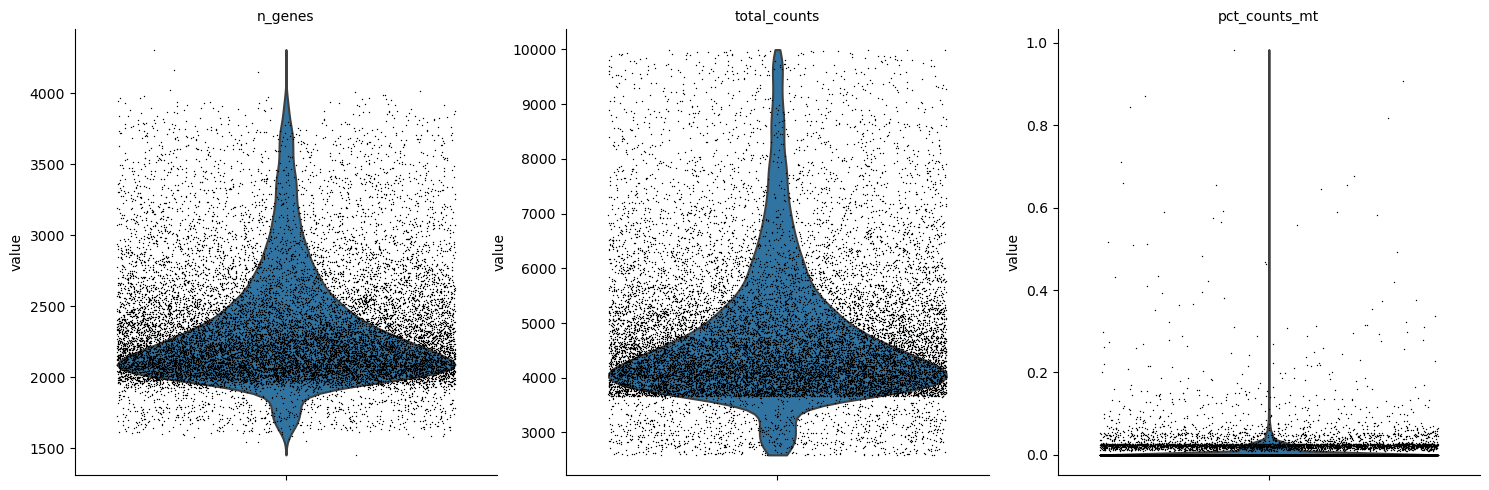

In [15]:
# A violin plot of some of the computed quality measures
sc.pl.violin(

    adata,
    ['n_genes', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True,
    save = True

)


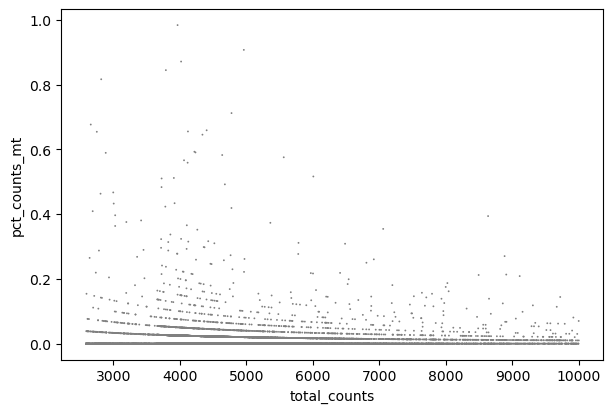

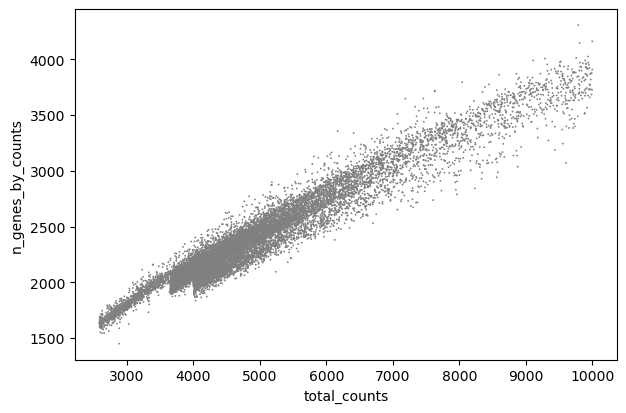

In [16]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', save = "_totalcounts_permt")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', save = "_totalcounts_ngenes")

In [17]:
adata

AnnData object with n_obs × n_vars = 17328 × 22010
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Doublet', 'Doublet Score', 'batch'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells-KO', 'n_cells_by_counts-KO', 'mean_counts-KO', 'pct_dropout_by_counts-KO', 'total_counts-KO', 'n_cells-WT', 'n_cells_by_counts-WT', 'mean_counts-WT', 'pct_dropout_by_counts-WT', 'total_counts-WT'

In [18]:
# Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [19]:
# Logarithmize the data (natural log (x+1))
sc.pp.log1p(adata)

In [20]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.25)
# This saves the original set of genes 
adata.raw = adata

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


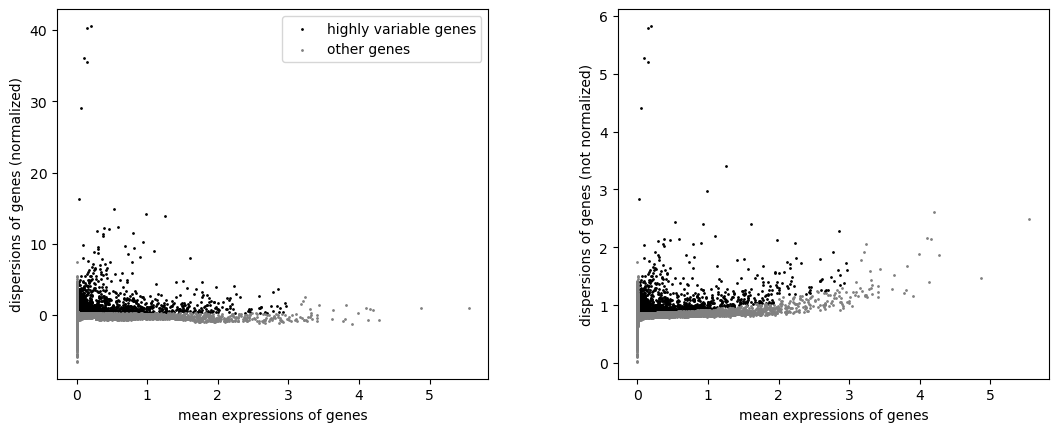

In [21]:
sc.pl.highly_variable_genes(adata)

In [22]:
adata = adata[:,adata.var.highly_variable]

In [23]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(
    
    adata,
    ['total_counts', 'pct_counts_mt']

)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:06)


In [24]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

In [25]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:14)


In [26]:
inferno = sns.color_palette("inferno").as_hex()

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


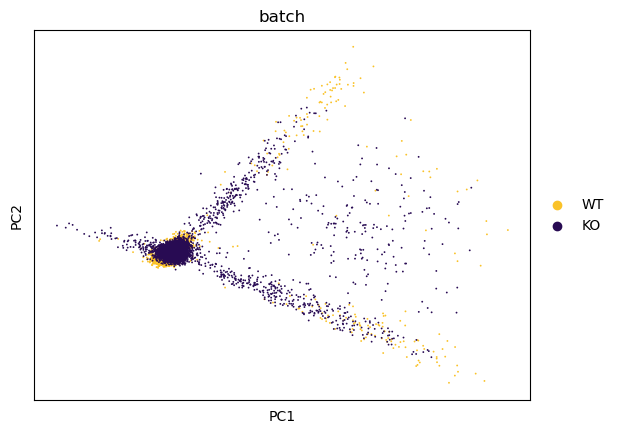

In [27]:
sc.pl.pca(
    
    adata,
    color = "batch",
    palette = [inferno[-1], inferno[0]],
    save = True
    
)

In [28]:
sc.pp.neighbors(adata, n_neighbors = 25, n_pcs = 40)
sc.tl.umap(adata)
sc.tl.leiden(adata)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:54)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:14)


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


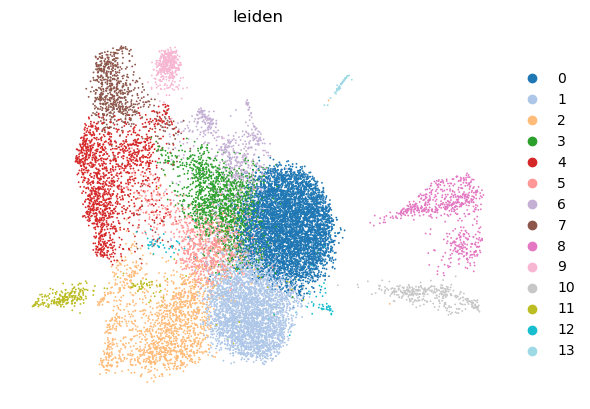

In [29]:
# UMAP (leiden)
sc.pl.umap(

    adata,
    color = ['leiden'],
    frameon = False,
    palette = "tab20",
    save = "_leiden"
    
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


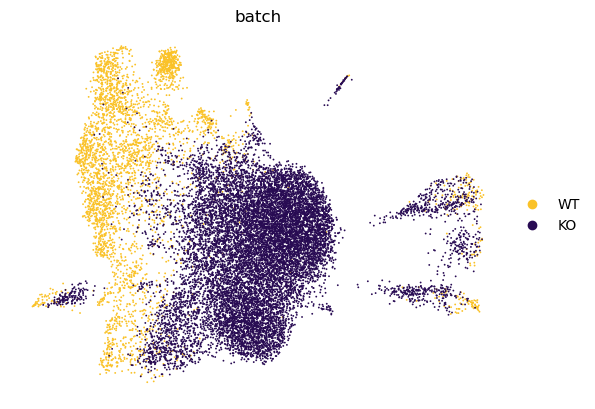

In [30]:
# UMAP (batch)
sc.pl.umap(
    
    adata,
    color = ['batch'],
    palette = [inferno[-1], inferno[0]],
    frameon = False,
    save = "_batch"

)

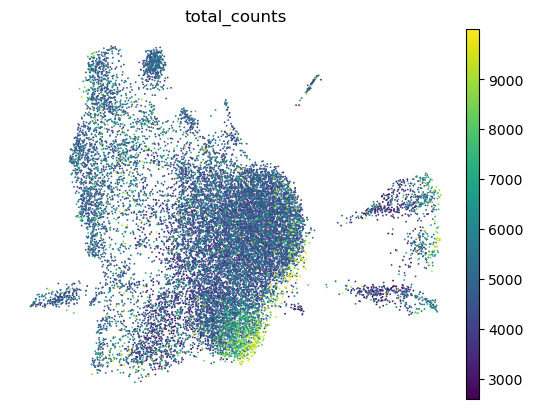

In [31]:
# Total counts
sc.pl.umap(
    
    adata,
    color = ['total_counts'],
    frameon = False,
    save = "_total_counts"

)

2023-09-23 11:46:28,543 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-09-23 11:46:43,931 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-09-23 11:46:44,109 - harmonypy - INFO - Iteration 1 of 10
2023-09-23 11:46:54,216 - harmonypy - INFO - Iteration 2 of 10
2023-09-23 11:47:04,161 - harmonypy - INFO - Iteration 3 of 10
2023-09-23 11:47:15,733 - harmonypy - INFO - Iteration 4 of 10
2023-09-23 11:47:28,426 - harmonypy - INFO - Iteration 5 of 10
2023-09-23 11:47:39,849 - harmonypy - INFO - Iteration 6 of 10
2023-09-23 11:47:51,374 - harmonypy - INFO - Iteration 7 of 10
2023-09-23 11:48:02,496 - harmonypy - INFO - Iteration 8 of 10
2023-09-23 11:48:09,540 - harmonypy - INFO - Iteration 9 of 10
2023-09-23 11:48:14,723 - harmonypy - INFO - Iteration 10 of 10
2023-09-23 11:48:20,963 - harmonypy - INFO - Stopped before convergence


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


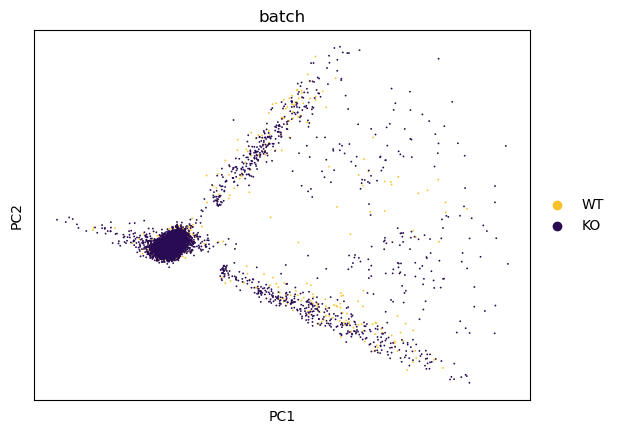

In [32]:
# Harmony
sc.external.pp.harmony_integrate(adata, 'batch')
adata_harmony = adata.copy()

adata_harmony.obsm['X_pca'] = adata_harmony.obsm['X_pca_harmony']

sc.pl.pca(
    
    adata_harmony,
    color = "batch",
    palette = [inferno[-1], inferno[0]],
    save = "_harmony"
    
)

In [33]:
sc.pp.neighbors(adata_harmony, n_neighbors=25)
sc.tl.umap(adata_harmony)
sc.tl.leiden(adata_harmony)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:07)


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


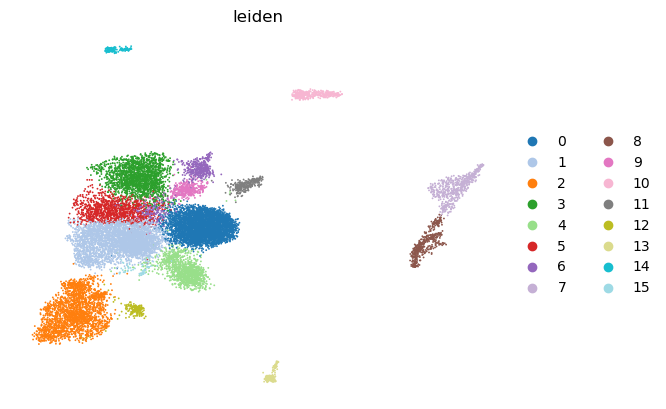

In [34]:
# UMAP (leiden)
sc.pl.umap(

    adata_harmony,
    color = ['leiden'],
    frameon = False,
    palette = "tab20",
    save = "_leiden_harmony"
    
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


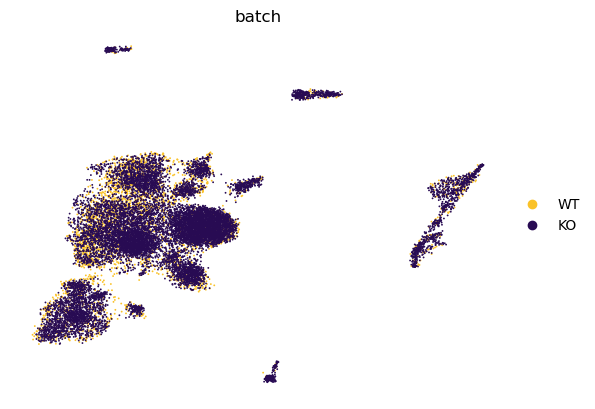

In [35]:
# UMAP (Group)
sc.pl.umap(
    
    adata_harmony,
    color = ['batch'],
    palette = [inferno[-1], inferno[0]],
    frameon = False,
    save = "_group_harmony"

)

In [36]:
adata_harmony

AnnData object with n_obs × n_vars = 17328 × 2468
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Doublet', 'Doublet Score', 'batch', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells-KO', 'n_cells_by_counts-KO', 'mean_counts-KO', 'pct_dropout_by_counts-KO', 'total_counts-KO', 'n_cells-WT', 'n_cells_by_counts-WT', 'mean_counts-WT', 'pct_dropout_by_counts-WT', 'total_counts-WT', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'batch_colors', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [37]:
adata_harmony.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,Doublet,Doublet Score,batch,leiden
AAACCCAAGACTTCAC-WT,2170,2170,4356.0,0.0,0.000000,False,0.411215,WT,1
AAACCCACAATACCCA-WT,2761,2761,6770.0,0.0,0.000000,False,0.094512,WT,9
AAACCCACACGCTTAA-WT,2479,2479,6218.0,2.0,0.032165,False,0.038835,WT,3
AAACCCAGTCGGCCTA-WT,2719,2719,6165.0,1.0,0.016221,False,0.035714,WT,1
AAACCCAGTGCTTCAA-WT,2294,2294,5443.0,1.0,0.018372,False,0.043922,WT,5
...,...,...,...,...,...,...,...,...,...
TTTGTTGCAAACAGGC-KO,2163,2163,4131.0,0.0,0.000000,False,0.234646,KO,4
TTTGTTGCAAATGCGG-KO,2377,2376,4442.0,0.0,0.000000,False,0.065246,KO,2
TTTGTTGCAGTAGTTC-KO,2131,2131,4105.0,1.0,0.024361,False,0.146637,KO,5
TTTGTTGTCCGCCTAT-KO,2974,2974,6705.0,0.0,0.000000,False,0.290807,KO,12


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


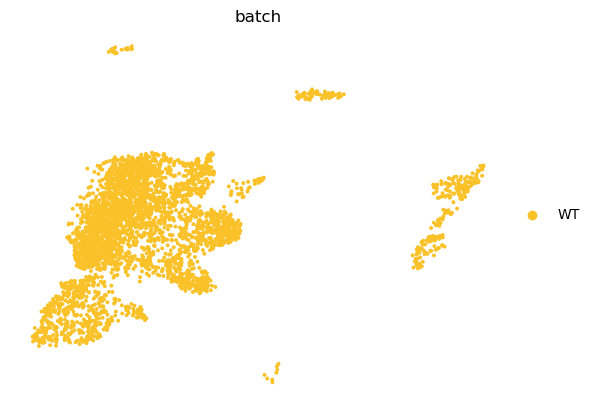

In [38]:
# UMAP (WT)
sc.pl.umap(
    
    adata_harmony[adata_harmony.obs.batch == "WT"],
    color = ['batch'],
    palette = [inferno[-1]],
    frameon = False,
    save = "_batch_harmony_WT"

)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


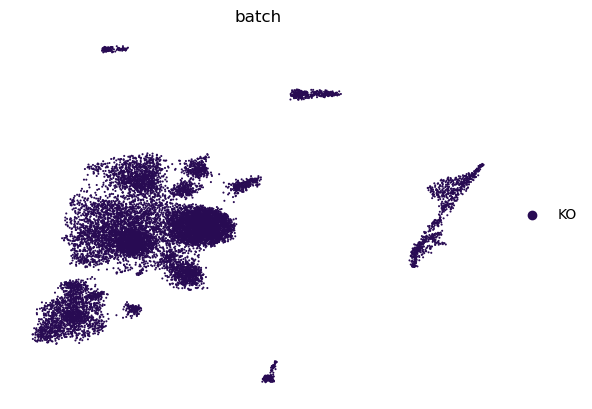

In [39]:
# UMAP (KO)
sc.pl.umap(
    
    adata_harmony[adata_harmony.obs.batch == "KO"],
    color = ['batch'],
    palette = [inferno[0]],
    frameon = False,
    save = "_batch_harmony_KO"

)

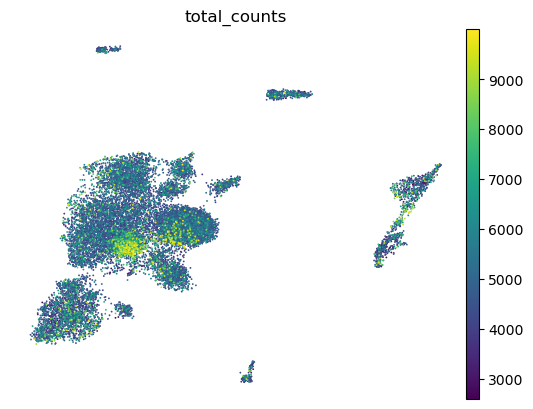

In [40]:
# Total counts
sc.pl.umap(
    
    adata_harmony,
    color = ['total_counts'],
    frameon = False,
    save = "_total_counts_harmony"

)

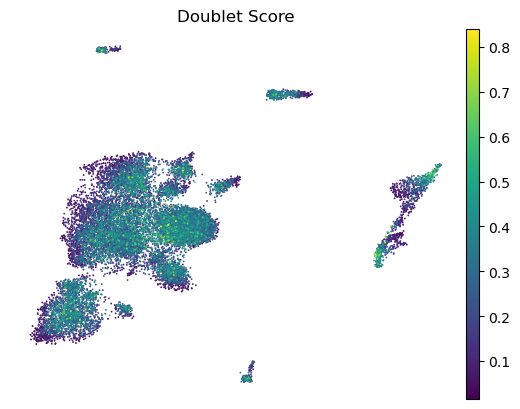

In [41]:
# Doublet score
sc.pl.umap(
    
    adata_harmony,
    color = ['Doublet Score'],
    frameon = False,
    save = "_Doublet_Score_harmony"

)

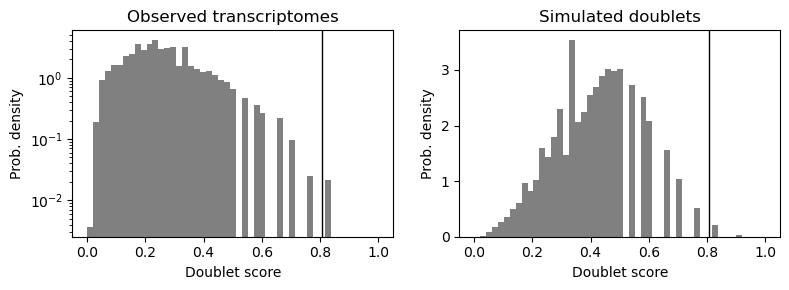

In [42]:
scrub.plot_histogram();

In [43]:
Doublet_dict = {True: "Yes", False: "No"}
adata_harmony.obs["Doublet or not"] = adata_harmony.obs["Doublet"].map(Doublet_dict)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


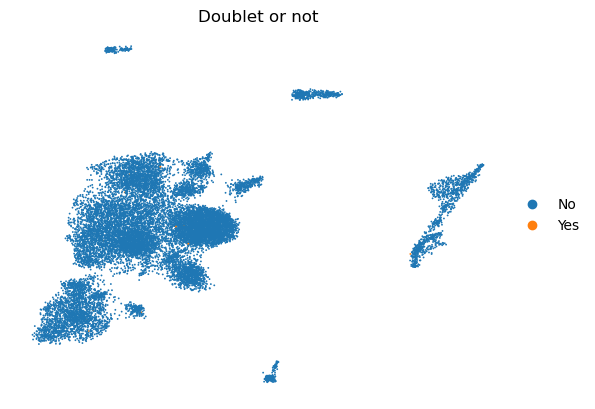

In [44]:
# Doublet
sc.pl.umap(
    
    adata_harmony,
    color = ['Doublet or not'],
    frameon = False,
    save = "_Doublet_harmony"

)

In [45]:
# Drop doublet
adata_harmony = adata_harmony[adata_harmony.obs.Doublet == False, :]

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


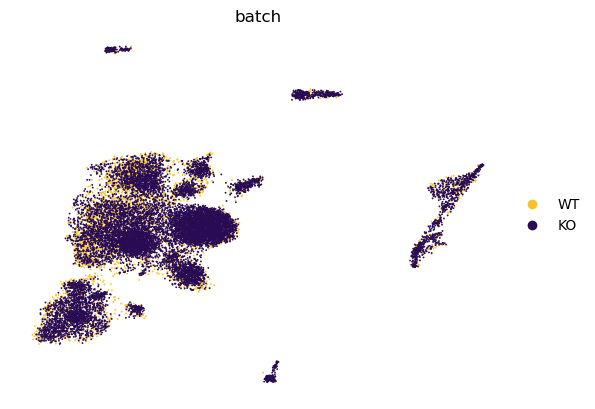

In [46]:
# UMAP (Group)
sc.pl.umap(
    
    adata_harmony,
    color = ['batch'],
    palette = [inferno[-1], inferno[0]],
    frameon = False,
    save = "_group_harmony"

)

In [50]:
# Save
adata_harmony.write(results_file)